# ML in Cybersecurity: Project III

## Team
  * **Team name**:  MMM
  * **Members**:  Maria Sargsyan (2576831,msargsyan@mpi-inf.mpg.de), Muneeb Aadil (2581794, maadil@mpi-inf.mpg.de), Muhammad Yaseen (2577833, myaseen@mpi-inf.mpg.de).
  * **Tutor**: *???*


## Logistics
  * **Due date**: 12th December 2019, 13:59:59 
  * Email the completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws1920_stud) to discuss.
  
## Timeline
  * 28-Nov-2019: Project 3 hand-out
  * **12-Dec-2019** (13:59:59): Email completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland

  * 19-Dec-2019: Project 3 discussion and summary
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset


# Debugging
import pdb

In [2]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [3]:
def identity_func(foo):
    return foo

def data_to_arrays(data):
    out1 = []
    out2 = []
    for d in data:
        x, y = d
        out1.append(x)
        out2.append(y)
    out1 = torch.cat(out1, dim=0)
    out2 = torch.IntTensor(out2)
    return out1, out2

class IncorrectPrediction:
    def __init__(self, true_label, predicted_label, image, prob_dist):
        self.true_label = true_label
        self.predicted_label = predicted_label
        self.image = image
        self.prob_dist = prob_dist
        

class AdversarialExample:
    
    def __init__(self, true_label, adv_label, 
                 true_image, adv_image, gen_method, 
                 true_score, adv_score):
        
        self.true_label = true_label
        self.adv_label  = adv_label
        self.true_image = true_image
        self.adv_image  = adv_image
        self.gen_method = gen_method
        self.true_score = np.exp(true_score)/np.sum(np.exp(true_score))
        self.adv_score  = np.exp(adv_score)/np.sum(np.exp(adv_score))
        
        
def get_accuracy_from_predictions(actual, predictions, verbose=False):

    assert actual.size() == predictions.size()
    incorrect = torch.sum(predictions != actual).item()
    total = float(actual.size()[0])
    acc = 1 - (incorrect / total)
    if verbose: 
      print('{0} predictions not correct from a total of {1}'.format(incorrect, total))
      print('Accuracy: {0}%'.format(acc*100))
    
    return acc

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Foolbox library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from project 1.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from project 1 here and train it until it achieves reasonable accuracy (>92%).

#### 1.1.1.1: Loading MNIST Data

Load and process MNIST data

In [4]:
# Loading MNIST data
BATCH_SIZE = 4
VALIDATION_FRACTION = 0.1
EPOCHS = 2
CLASSES = [str(i) for i in range(0,10)]

tsfms = transforms.Compose([
    transforms.ToTensor(),  # data loader returns a PIL image, we need to transform it to a Tensor object
])

# train and test datasets, transformed to a tensor
mnist_train_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=True, transform=tsfms)
mnist_val_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=True, transform=tsfms)
mnist_test_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=False, transform=tsfms)

# we need to create a disjoint validation set from within the training set
# following the approach taken in this link
# https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb

num_training = len(mnist_train_data)
all_indices = list(range(num_training)) # this gives us indices over the whole training set
split = int(np.floor( VALIDATION_FRACTION * num_training))
# split indices into disjoint sets
train_indices, val_indices = all_indices[split:], all_indices[:split]

# now we have the indices for train and val sets, we create a pytorch 
# custom sampler over both datasets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# represents a data loader, takes care of random batching and indexing etc.
mnist_train_data_loader = torch.utils.data.DataLoader(mnist_train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
mnist_val_data_loader   = torch.utils.data.DataLoader(mnist_val_data, batch_size=BATCH_SIZE, sampler=val_sampler)
mnist_test_data_loader  = torch.utils.data.DataLoader(mnist_test_data, batch_size=1, shuffle=False)

#### 1.1.1.2: Defining the Model

Define the CNN Model

In [5]:
# Model represented as class

class CNNModel(nn.Module):

    def __init__(self):
    
        super(CNNModel, self).__init__()

        ## formula to make sure params work out
        ## W_out = (W_in - F)/S + 1
        ## from http://cs231n.github.io/convolutional-networks/

        ## we will have 2 conv layers

        # in_channel is 1 bcz MNIST is a BW dataset
        # from 1 input, we create 6 output feature maps, using 5x5 kernels
        # input is 28x28, output will be 24x24
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

        # max pool over the 2x2 region.
        # input is 24x24, output will be 12x12 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # after max pool, out spatial dim is reduced, but num channels coming from 
        # prev conv1 is still 6. We create 16 feature maps, again using 5x5 kernels
        # input is 12x12, output will be 8x8
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # max pool over the 2x2 region. 
        # input is 8x8, output will be 4x4
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        ## followed by 2 FC layers, y = Wx + b
        # we take features computer after the pool2 step.
        # we have 16 maps, each of size 4x4. We will flatten them
        self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)

        ## and a last FC layer for predictions
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    # we define the fwd pass, backward pass is automatically defined 
    # by PyTorch thru lineage

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # flatten
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.tanh(self.fc1(x))
        #x = F.tanh(self.fc2(x))
        x = self.fc3(x)

        return x

In [6]:
# Function to test the model on a give (sub)set.

def test_model(cnn_model, is_test_set=False, verbose=False):

    class_preds = []
    ground_truth = []
    incorrect_predictions = []
    TEST = is_test_set


    with torch.no_grad():
        for data in mnist_test_data_loader if TEST else mnist_val_data_loader:
            images, labels = data

            # get (unnormalized) predictions
            predictions = cnn_model(images)
            # normalize to get probability distribution
            batch_class_probabilities = [F.softmax(el, dim=0) for el in predictions]
            # get index of max value which corresponds to the predicted label
            # we discard actual values because they are of no use as we use 
            # probability dist
            _, predicted_labels = torch.max(predictions, 1)

            # we save some of the incorrect predictions to view them later for 
            # insights and reasoning
            for i,(t,p) in enumerate(zip(labels.tolist(),predicted_labels.tolist())):
                if t != p:
                    incorrect_predictions.append(IncorrectPrediction(t,p,images[i],batch_class_probabilities[i]))

            ground_truth.append(labels)
            #class_probs.append(batch_class_probabilities)
            class_preds.append(predicted_labels)

    # concat predictions from all batches to get a single vector
    test_preds = torch.cat(class_preds)
    # actual labels
    ground_truth = torch.cat(ground_truth)
    # calculate accuracy in percentage given predictions and ground truth
    accuracy = get_accuracy_from_predictions(ground_truth, test_preds, verbose=verbose)

    return accuracy, incorrect_predictions

#### 1.1.1.3: Defining the Loss function, Optimization, and Training Loop

In [8]:
# initialize an instance of CNN model
cnn_model = CNNModel()

# automatically takes care of one-hot encoding the labels 
# https://pytorch.org/docs/stable/nn.html#crossentropyloss
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

running_loss = 0.0
val_acc_history = []
loss_history = []

best_model = None
best_val_acc = None
# the training loop
for epoch in range(EPOCHS):

    print("Epoch [{} / {}]".format(epoch+1, EPOCHS))
    for i, data in tqdm(enumerate(mnist_train_data_loader, 0)):

        inputs, labels = data
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 1000 == 999:
            loss_per_1k = running_loss / 1000.0
            loss_history.append(loss_per_1k)
            
            val_acc, _ = test_model(cnn_model, is_test_set=False)
            val_acc_history.append(val_acc)
            
            print("Loss: {0} \t Validation Accuracy: {1}%".format(str(loss_per_1k), str(val_acc*100)))
            
            running_loss = 0.0

print("Finished training")

9it [00:00, 78.75it/s]

Epoch [1 / 2]


1021it [00:08, 24.52it/s]

Loss: 2.294882250070572 	 Validation Accuracy: 25.4%


2026it [00:19, 16.06it/s] 

Loss: 1.5563014516271652 	 Validation Accuracy: 81.96666666666667%


3014it [00:32, 11.55it/s] 

Loss: 0.42080974123906345 	 Validation Accuracy: 91.96666666666667%


4023it [00:42, 22.96it/s] 

Loss: 0.26908470528037287 	 Validation Accuracy: 93.63333333333334%


5019it [00:52, 19.40it/s] 

Loss: 0.21000112865847767 	 Validation Accuracy: 95.39999999999999%


6020it [01:02, 25.43it/s] 

Loss: 0.15966528247332462 	 Validation Accuracy: 96.03333333333333%


7013it [01:12, 16.85it/s] 

Loss: 0.17007265138000366 	 Validation Accuracy: 94.71666666666667%


8007it [01:19, 36.15it/s] 

Loss: 0.1499237997391465 	 Validation Accuracy: 96.0%


9013it [01:28, 26.35it/s] 

Loss: 0.14298264545518033 	 Validation Accuracy: 95.89999999999999%


10026it [01:37, 23.96it/s]

Loss: 0.1366205158978919 	 Validation Accuracy: 95.68333333333334%


11024it [01:47, 26.58it/s] 

Loss: 0.11142310378432739 	 Validation Accuracy: 97.13333333333334%


12025it [01:56, 29.00it/s] 

Loss: 0.11915542259835638 	 Validation Accuracy: 97.23333333333333%


13024it [02:10, 15.71it/s] 

Loss: 0.09695178625350309 	 Validation Accuracy: 97.43333333333334%


13500it [02:13, 101.23it/s]
25it [00:00, 249.01it/s]

Epoch [2 / 2]


1036it [00:07, 19.01it/s]

Loss: 0.14563944652492136 	 Validation Accuracy: 96.65%


2015it [00:15, 37.61it/s] 

Loss: 0.08006627682904946 	 Validation Accuracy: 97.5%


3012it [00:26, 13.14it/s] 

Loss: 0.0832274521874424 	 Validation Accuracy: 97.15%


4024it [00:37, 19.94it/s] 

Loss: 0.0844800882551899 	 Validation Accuracy: 97.85000000000001%


5002it [00:50, 11.37it/s] 

Loss: 0.08467935696671157 	 Validation Accuracy: 96.33333333333334%


6032it [01:01, 28.82it/s] 

Loss: 0.07876643193680957 	 Validation Accuracy: 97.66666666666667%


7020it [01:09, 28.21it/s] 

Loss: 0.06785180580786891 	 Validation Accuracy: 97.86666666666667%


8018it [01:19, 25.90it/s] 

Loss: 0.07035395660849736 	 Validation Accuracy: 97.66666666666667%


9001it [01:28, 18.94it/s] 

Loss: 0.07824270795823213 	 Validation Accuracy: 97.11666666666666%


10033it [01:39, 33.54it/s]

Loss: 0.08024027081369287 	 Validation Accuracy: 97.65%


10627it [01:43, 188.31it/s]

KeyboardInterrupt: 

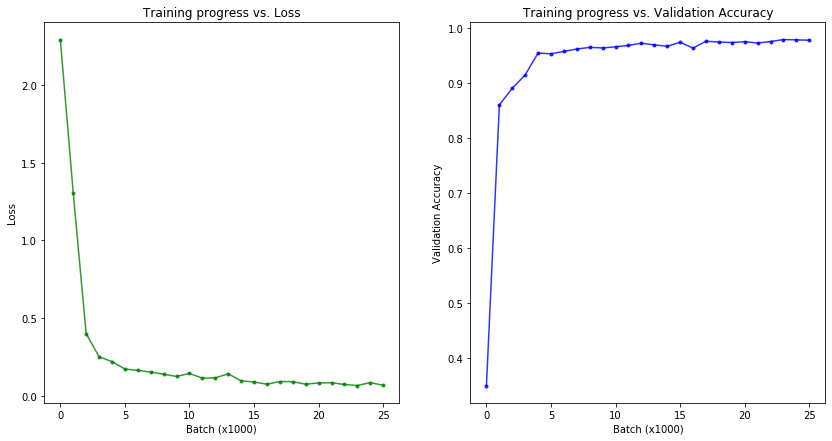

<Figure size 432x288 with 0 Axes>

In [14]:
# Visualize trainset performance

# plot loss curve per 1000 batches (per 4000 examples if BS = 4)
# Note: we didn't plot it against num_epochs because we didn't run many epochs as network 
# converges after 1 or 2. We thought it would be more interesting to see trends b/w batches.
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ax[0].plot(range(len(loss_history)), loss_history,  
         color='g', alpha=0.8, marker='.')
ax[0].set( 
    xlabel='Batch (x1000)', 
    ylabel='Loss', 
    title='Training progress vs. Loss')


# plot val acc per 1000 batches (per 4000 examples if BS = 4)
ax[1].plot(range(len(val_acc_history)), val_acc_history,  
         color='b', alpha=0.8, marker='.')
ax[1].set( 
    xlabel='Batch (x1000)', 
    ylabel='Validation Accuracy', 
    title='Training progress vs. Validation Accuracy')
plt.show()
plt.tight_layout()

#### 1.1.1.4: Evaluation

Before attacking the model, we need to make sure that it achieves >95% accuracy on test set.


In [16]:
accuracy, incorrect_predictions = test_model(cnn_model, is_test_set=True, verbose=False)
print('Accuracy on unseen test data is {0}%'.format(accuracy*100))

Accuracy on unseen test data is 97.94%


In [19]:
# save the trained model.
MODEL_SAVE_PATH = './victim-model.pth'
torch.save(cnn_model.cpu().state_dict(), MODEL_SAVE_PATH)

### 1.1.2: Implementing an attack (15 Points)

We now want you to attack the model trained in the previous step. Please implement the FGSM attack mentioned in the lecture. 

In [8]:
def FGSM(model, Xtrue, Ytrue, criterion, epsilon=0.01, min_val=0, max_val=1):
    """
    Implements the one step FGSM attack.
    
    Args:
        
    Returns:
    """
    # we use this for calculating gradients for image,
    Xtrue.requires_grad = True
    # which is turned off by default.
    
    Ypred = model(Xtrue)
    _, pred_classes_before = torch.max(Ypred, dim=1)
    pred_classes_before = pred_classes_before.data

    # TODO: generalize min_val and max_val variables.
    loss = criterion(Ypred, Ytrue)
    
    # calculate gradients
    model.zero_grad()
    loss.backward()
    
    # pdb.set_trace()
    
    with torch.no_grad():
        grad_sign = Xtrue.grad.data.sign()
        Xperturbed = Xtrue.data + (epsilon * grad_sign)
        Xperturbed = torch.clamp(Xperturbed, min=0, max=1)
        
        Ypred_ = model(Xperturbed)
        _, pred_classes_after = torch.max(Ypred_, dim=1)
        pred_classes_after = pred_classes_after.data
        
    return Xperturbed, pred_classes_before, pred_classes_after

In [9]:
# load the trained model
MODEL_LOAD_PATH = './victim-model.pth'
victim_model = CNNModel().to(device)
victim_model.load_state_dict(torch.load(MODEL_LOAD_PATH))
victim_model.eval()

criterion = torch.nn.CrossEntropyLoss().to(device)

epsilons = np.linspace(0.01, 0.3, num=10)

In [9]:
# for (Xtest, Ytest) in tqdm(mnist_test_data_loader):
#     Xtest = Xtest.to(device)
#     Ytest = Ytest.to(device)
#     Yperturbed, preds_before, preds_after = FGSM(victim_model, Xtest, Ytest, criterion, epsilon=.3)

### 1.1.3: adversarial sample set (5 Points)

Please additionally generate a dataset containing at least 1,000 adversarial examples using FGSM.

In [9]:
def create_dataset(model, loader, criterion, device, epsilon=0.2, max_limit=2000):
    curr_adv_samples = 0
    advXtrue, advXnew, advYtrue, advYnew = [], [], [], []
    for (Xtest, Ytest) in tqdm(loader):
        Xtest = Xtest.to(device)
        Ytest = Ytest.to(device)
        Yperturbed, preds_before, preds_after = FGSM(model ,Xtest, Ytest,
                                                     criterion, epsilon=epsilon)
        if (preds_before == Ytest) and (preds_before != preds_after):
            advXtrue.append(Xtest.data)
            advXnew.append(Yperturbed)
            advYtrue.append(preds_before)
            advYnew.append(preds_after)
            
            curr_adv_samples += 1

        if curr_adv_samples == max_limit:
            break

    advXtrue = torch.cat(advXtrue, dim=0)
    advXnew = torch.cat(advXnew, dim=0)
    advYtrue = torch.cat(advYtrue, dim=0)
    advYnew = torch.cat(advYnew, dim=0)
    
    return (advXtrue, advXnew, advYtrue, advYnew)

adv_dataset = create_dataset(victim_model, mnist_test_data_loader, criterion, device)

 31%|███       | 3123/10000 [00:15<00:34, 198.53it/s]

### 1.1.3: Visualizing the results (5 Points)

Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

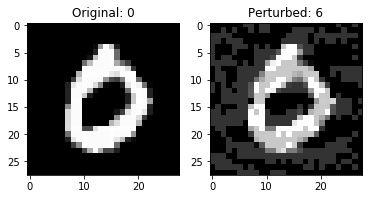

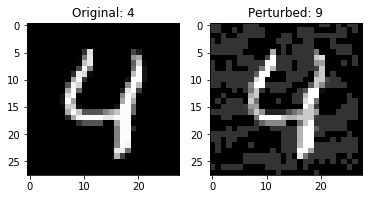

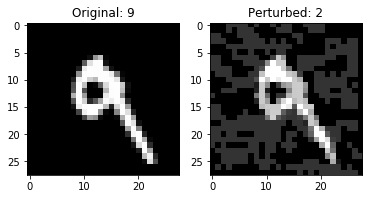

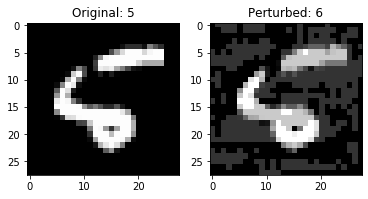

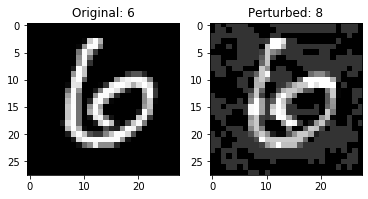

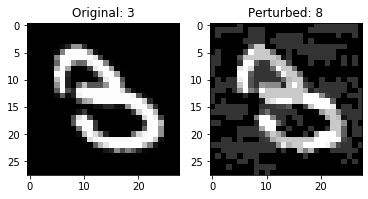

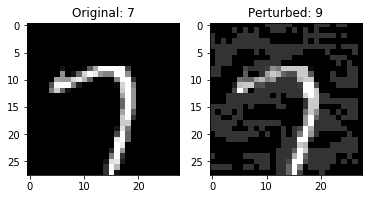

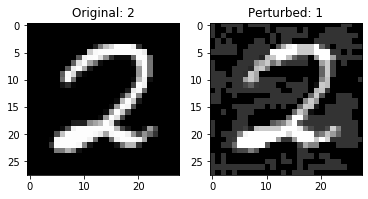

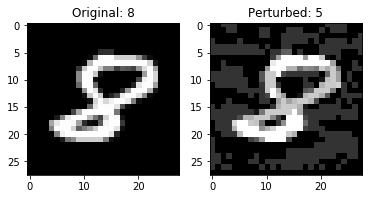

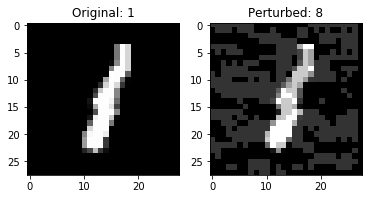

In [30]:
classes_done = [False] * 10 # number of classes.
advXtrue, advXnew, advYtrue, advYnew = adv_dataset

for i in range(len(advXtrue)):
    # print("i: {}".format(i))
    if not classes_done[advYtrue[i]]:
        # pdb.set_trace()
        classes_done[int(advYtrue[i])] = True
        fig, ax = plt.subplots(ncols=2)
        
        ax[0].imshow(advXtrue[i, 0])
        ax[0].set_title("Original: {}".format(int(advYtrue[i])))
        
        ax[1].imshow(advXnew[i, 0])
        ax[1].set_title("Perturbed: {}".format(int(advYnew[i])))
        
    if sum(classes_done) == 10:
        break

### 1.2.1: Using libraries for attacks (10 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the Foolbox (https://github.com/bethgelab/foolbox) library. Please implement two other (recent, advanced) attacks of your choice using this library. 

In [60]:
# Chosen attacks
# (a) Spatial Attack (adversarial rotations and translations)

import foolbox
import numpy as np
import torchvision.models as models


def attack_model(victim_model, max_adv_examples, attack_name, **attack_params):
    
    """
    what data to attack on?
    """
    print("attacking vica " + attack_name)
    supported_attacks = ['spatial', # Spatial Attack
                         'boundary', # Boundary Attack
                        ]
    assert attack_name in supported_attacks, "Attack Not supported"
    
    fmodel = foolbox.models.PyTorchModel(victim_model, bounds=(0, 1), 
                                     num_classes=10)
    adversarial_examples = []
      
    # initialize attack
    attack = None
    
    if attack_name == 'spatial':
        attack = foolbox.attacks.SpatialAttack(fmodel)
    if attack_name == 'boundary':
        attack = foolbox.attacks.SpatialAttack(fmodel)
        
    for i, data in tqdm(enumerate(mnist_train_data_loader, 0)):

        inputs, labels = data
        #print(inputs.shape)
        #print(labels.shape)
        
        #break
        
        adversarials = attack(inputs.numpy(), labels.numpy())
        
        # we need to iter over batch to construct our object
        for b in range(0, BATCH_SIZE):
            
            adversarial_examples.append(
                AdversarialExample(
                    true_label  = labels[b],
                    adv_label   = torch.argmax(
                                     victim_model(
                                        torch.unsqueeze(torch.Tensor(adversarials[b]),1)
                                     )
                                  ).detach().numpy(),        # from tensor to numpy
                    true_image  = inputs[b].squeeze(),       # get rid of batch dimension
                    adv_image   = adversarials[b].squeeze(), # get rid of batch dimension
                    gen_method  = attack_name,
                    true_score  = victim_model(torch.unsqueeze(inputs[b],1)).detach().numpy()[0],
                    adv_score   = victim_model(torch.unsqueeze(torch.Tensor(adversarials[b]),1)).detach().numpy()[0],
                )
            )
        
        if len(adversarial_examples) >= max_adv_examples:
            break
    
    return adversarial_examples

In [61]:
MODEL_SAVE_PATH = './victim-model.pth'
tried_attacks = ['spatial', 'boundary']
found_adversaries = {}

# instantiate model
victim_model = CNNModel()
victim_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
victim_model.eval()

for atk in tried_attacks:
    print(atk)
    found_adversaries[atk] = attack_model(victim_model, max_adv_examples=4, attack_name=atk, attack_params=None)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

spatial
attacking vica spatial
boundary
attacking vica boundary


dict_keys(['spatial', 'boundary'])


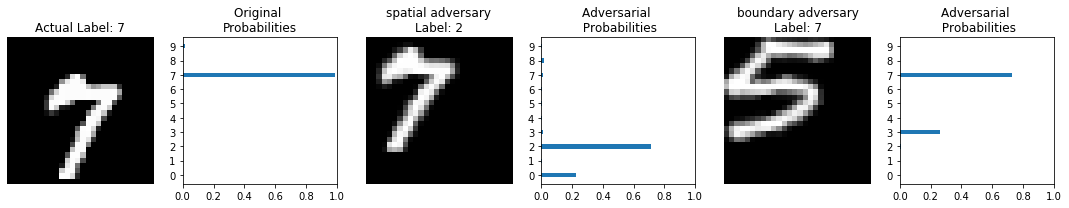

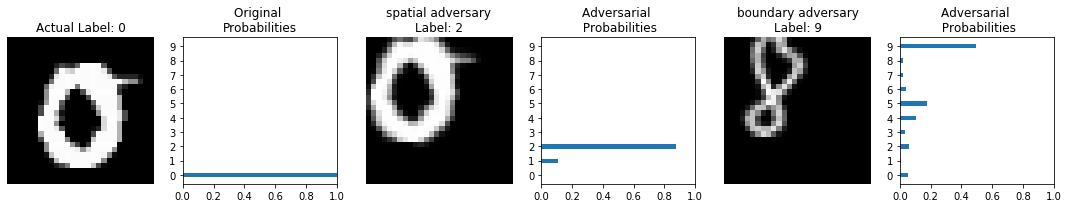

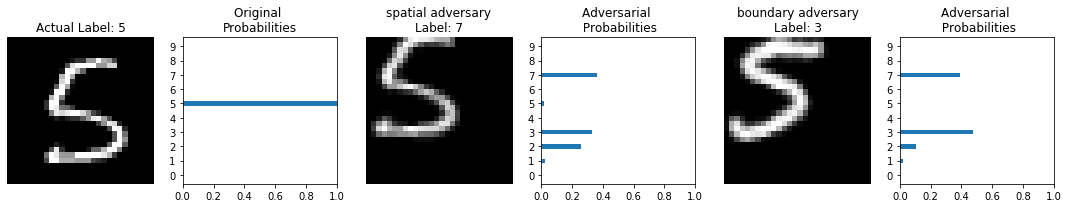

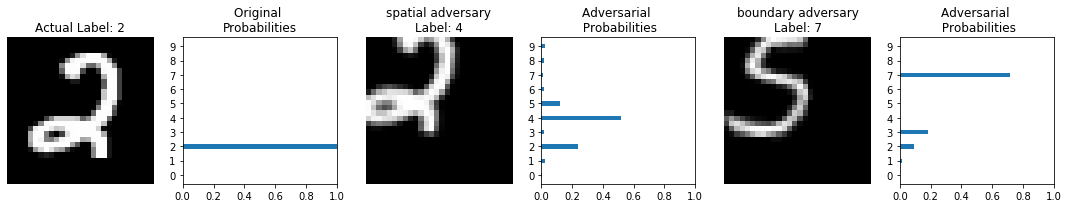

In [72]:
print(found_adversaries.keys())

num_adv=4

for i in range(0,num_adv):
    
    fig, ax = plt.subplots(ncols=2*len(tried_attacks) + 2, nrows = 1,figsize=(15,3))
    
    ax[0].imshow(found_adversaries[tried_attacks[0]][i].true_image,cmap='gray')
    ax[0].axis('off') # no need to show axes on images
    ax[0].set_title("Actual Label: {0}".format(found_adversaries[tried_attacks[0]][i].true_label))
    
    ax[1].barh(list(range(0,10)), found_adversaries[tried_attacks[0]][i].true_score, 0.3)
    ax[1].set_yticks(list(range(0,10))) # needed to show all class labels on y axis
    ax[1].set_xlim([0,1])
    ax[1].set_title("Original \nProbabilities")
    
    idx = 2
    
    for atk in tried_attacks:    
        
        ax[idx].imshow(found_adversaries[atk][i].adv_image,cmap='gray')
        ax[idx].axis('off')
        ax[idx].set_title(
            found_adversaries[atk][i].gen_method + " adversary\n" + 
            "Label: " + str(found_adversaries[atk][i].adv_label))
        
        ax[idx+1].barh(list(range(0,10)), found_adversaries[atk][i].adv_score, 0.3)
        ax[idx+1].set_yticks(list(range(0,10))) # needed to show all class labels on y axis
        ax[idx+1].set_xlim([0,1]) # need to do this, so bars are comparable visually.
        ax[idx+1].set_title("Adversarial \n Probabilities")
        
        idx = idx + 2
        
    plt.tight_layout()

### 1.2.2: Visualizing the results (20 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (FGSM, 2 methods from Foolbox).


In [0]:
col_titles = ['Ori','FGSM','Method 1', 'Method 2'] 
nsamples = 10
nrows = nsamples
ncols = len(col_titles)

fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
[ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

for ax, col in zip(axes[0], col_titles): # set up the title for each column
    ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

for i in range(nsamples):
    axes[i,0].imshow(images_ori[i])
    axes[i,1].imshow(adv_FGSM[i])
    axes[i,2].imshow(adv_Method1[i])
    axes[i,3].imshow(adv_Method2[i])
                  

Which differences do you observe when comparing different attack methods? Why?   
Please write a brief summary of your findings.   
* Does the attack always succeed (the model make wrong prediction on the adversarial sample)?
* How different is the adversarial sample from the original image?
(L0,L2,Linf norm)  
* How about the computation cost of each attack method?
* Does the attack require white-box access to the model?
* .....

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM.   
Also, you are encouraged (optional) to defend against the two other attack methods, i.e. you are free to increase this special test set (for example by >30 examples (>10 from your FGSM attack, >10 from both the two other attacks of the library)).

### 2.1.1. Defense Solution: Distillation [1]

[1] Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks

### 2.1.2. Trainer Function with Temperature

In [7]:
# Reference model (whose probabilities are to be distilled in second network)
def train_with_temperature(model, loss_fn, loader, optimizer, epochs, temperature):
    running_loss = 0.0
    val_acc_history = []
    loss_history = []

    # the training loop
    for epoch in range(epochs):

        print("Epoch [{} / {}]".format(epoch+1, epochs))
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            outputs = outputs / temperature # softening in distillation
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 1000 == 999:
                loss_per_1k = running_loss / 1000.0
                loss_history.append(loss_per_1k)

                val_acc, _ = test_model(model, is_test_set=False)
                val_acc_history.append(val_acc)

                print("Loss: {0} \t Validation Accuracy: {1}%".format(str(loss_per_1k), str(val_acc*100)))

                running_loss = 0.0

    print("Finished training")
    
    return val_acc_history, loss_history, model

### 2.1.3. Distillation Function

In [8]:
def distil(teacher, student, loader, optimizer, epochs, temperature, alpha=.5):
    running_loss = 0.0
    val_acc_history = []
    loss_history = []
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        print("Epoch [{} / {}]".format(epoch+1, epochs))
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data
            optimizer.zero_grad()
            
            teacher_outputs = teacher(inputs)
            teacher_outputs = teacher_outputs / temperature
            
            student_outputs = student(inputs)
            student_outputs = student_outputs / temperature
            
            # pdb.set_trace()
            loss = loss_fn(student_outputs, teacher_outputs)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if i % 1000 == 999:
                loss_per_1k = running_loss / 1000.0
                loss_history.append(loss_per_1k)

                val_acc, _ = test_model(student, is_test_set=False)
                val_acc_history.append(val_acc)

                print("Loss: {0} \t Validation Accuracy: {1}%".format(str(loss_per_1k), str(val_acc*100)))

                running_loss = 0.0
                
    print("Finished Distillation")
    return val_acc_history, loss_history, student

# distillation loss (via KL Divergence)
# def KLDivergence(student_outputs, teacher_outputs, labels, alpha, temperature):
#     """
#     Compute the KLDivergence for knowledge-distillation (KD) loss
#     """
#     KD_loss = nn.KLDivLoss()(F.log_softmax(student_outputs, dim=1),
#                              F.softmax(teacher_outputs, dim=1)) * (alpha * temperature ** 2) + \
#               F.cross_entropy(student_outputs, labels) * (1. - alpha)
#     return KD_loss

### 2.1.3. Training a Teacher Model with Temperature

In [9]:
teacher_model = CNNModel().to(device)
student_model = CNNModel().to(device)

loss_fn_teacher = nn.CrossEntropyLoss().to(device)
loss_fn_student = nn.Sequential()

optimizer_teacher = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9)
optimizer_student = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.0)

t = 2 # temperature for distillation
e = 1 # epochs

print("Training a reference model...")
_, _, teacher_model = train_with_temperature(
    teacher_model, loss_fn_teacher, mnist_train_data_loader, optimizer_teacher,
    epochs=e, temperature=t
)

16it [00:00, 150.23it/s]

Training a reference model...
Epoch [1 / 1]


1026it [00:07, 38.91it/s]

Loss: 2.2978703014850614 	 Validation Accuracy: 25.483333333333334%


2032it [00:15, 22.90it/s] 

Loss: 1.9661988590955735 	 Validation Accuracy: 68.95%


3018it [00:23, 25.52it/s] 

Loss: 0.6693270396851003 	 Validation Accuracy: 85.45%


4016it [00:33, 22.07it/s] 

Loss: 0.3998145756693557 	 Validation Accuracy: 91.33333333333333%


5025it [00:42, 21.25it/s] 

Loss: 0.2946504022185691 	 Validation Accuracy: 90.36666666666666%


6014it [00:54, 10.95it/s] 

Loss: 0.22434089775412577 	 Validation Accuracy: 93.85%


7039it [01:03, 40.92it/s] 

Loss: 0.20435042646792134 	 Validation Accuracy: 95.38333333333333%


8039it [01:10, 40.89it/s] 

Loss: 0.1831768142671499 	 Validation Accuracy: 96.16666666666667%


9028it [01:19, 36.74it/s] 

Loss: 0.16898743451258633 	 Validation Accuracy: 95.48333333333333%


10041it [01:26, 41.31it/s]

Loss: 0.14349058623802557 	 Validation Accuracy: 95.78333333333333%


11021it [01:33, 39.07it/s] 

Loss: 0.141635035978019 	 Validation Accuracy: 96.75%


12020it [01:41, 36.96it/s] 

Loss: 0.11567836056133092 	 Validation Accuracy: 96.68333333333334%


13018it [01:48, 24.63it/s] 

Loss: 0.12410334287862497 	 Validation Accuracy: 97.11666666666666%


13500it [01:51, 121.48it/s]

Finished training


In [ ]:
distil(teacher_model, student_model, mnist_train_data_loader, optimizer_student,
       epochs=1, temperature=t, alpha=.9)

7it [00:00, 68.04it/s]

Epoch [1 / 1]


1018it [00:10, 24.15it/s]

Loss: 24.76996211051941 	 Validation Accuracy: 9.183333333333332%


2015it [00:20, 29.03it/s] 

Loss: 21.52526346874237 	 Validation Accuracy: 30.45%


3012it [00:29, 27.96it/s] 

Loss: 10.102861761569978 	 Validation Accuracy: 74.78333333333333%


4023it [00:40, 23.18it/s] 

Loss: 4.560809969425201 	 Validation Accuracy: 84.86666666666667%


5017it [00:50, 21.46it/s] 

Loss: 2.6620885362625124 	 Validation Accuracy: 90.25%


6012it [01:01, 17.93it/s] 

Loss: 1.6605404943525792 	 Validation Accuracy: 92.58333333333333%


7020it [01:11, 18.96it/s] 

Loss: 1.1898319874554872 	 Validation Accuracy: 93.5%


8004it [01:20, 21.77it/s] 

In [0]:

print('Accuracy on adversarial samples (FGSM) %.2f'%acc_FGSM)
print('Accuracy on adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend)

### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. 

* What did you try to make the classifier more robust against FGSM? 
* Why did it work? 
* Is the classifier now robust against FGSM?  
* ...

Feel free to state any interesting finding you encountered during this project.

In [18]:
import torch

In [13]:
import torch


In [ ]:
torch.LongTensor